# Live Football Updates

Using the API made available by https://www.football-data.org/ we will apply the principals from the background notebook in the same directory as this notebook.  For this notebook to work, an environment variable called `FOOTBALL_DATA_ORG_API_TOKEN` must be set before loading this Jupyter notebook.  To get a token, go to https://www.football-data.org/client/register .

The code below ensures that subsequent code follows Python best practices.

In [1]:
# Enable PEP8 code checking.
%load_ext pycodestyle_magic

%pycodestyle_on

The code belows imports all the packages that we require and makes calls to the Football Data API.  It should only be executed once to ensure we do not over excercise the API which is provided for free.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from matplotlib.ticker import PercentFormatter
from scipy.stats import poisson

# Get the API token from the operating system environment.
api_token = os.environ['FOOTBALL_DATA_ORG_API_TOKEN']

headers = {'X-Auth-Token': api_token}
url = 'http://api.football-data.org/v2/competitions/2021/standings'
standings_response = requests.get(url, headers=headers)

url = 'http://api.football-data.org/v2/competitions/2021/matches'
url = f'{url}?status=SCHEDULED'
matches_response = requests.get(url, headers=headers)

/Users/ben.dalling/.pyenv/versions/3.8.2/envs/jupyter-notebooks/lib/python3.8/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Home Table

In [3]:
standings = standings_response.json()['standings']
tables = {}

for standing in standings:
    if standing['type'] == 'HOME':
        tables['HOME'] = standing['table']
    elif standing['type'] == 'AWAY':
        tables['AWAY'] = standing['table']

data = {
    'AWAY': [],
    'HOME': []
}

for t in ['HOME', 'AWAY']:
    table = tables[t]

    for item in table:
        points = (item['won'] * 3) + item['draw']

        row = [
            item['team']['name'],
            item['playedGames'],
            item['won'],
            item['draw'],
            item['lost'],
            item['points'],
            item['goalsFor'],
            item['goalsAgainst'],
            item['goalDifference'],
            points
        ]

        data[t].append(row)

columns = list(item.keys())
columns.append('points')
columns.remove('position')

home_df = pd.DataFrame(data['HOME'], columns=columns)
away_df = pd.DataFrame(data['AWAY'], columns=columns)
home_df

,team,playedGames,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,points
0,Liverpool FC,18,17,1,0,52,47,13,34,52
1,Manchester City FC,18,14,2,2,44,52,13,39,44
2,Tottenham Hotspur FC,19,12,3,4,39,36,17,19,39
3,Leicester City FC,18,11,4,3,37,35,15,20,37
4,Manchester United FC,18,10,6,2,36,39,16,23,36
5,Chelsea FC,18,10,3,5,33,28,16,12,33
6,Arsenal FC,18,9,6,3,33,33,22,11,33
7,Sheffield United FC,18,10,3,5,33,24,14,10,33
8,Everton FC,18,8,7,3,31,23,18,5,31
9,Wolverhampton Wanderers FC,18,7,7,4,28,25,19,6,28


## Away Table

In [4]:
away_df

,team,playedGames,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,points
0,Liverpool FC,18,13,2,3,41,30,16,14,41
1,Manchester City FC,18,10,1,7,31,41,22,19,31
2,Southampton FC,19,9,4,6,31,30,25,5,31
3,Chelsea FC,18,9,3,6,30,36,33,3,30
4,Wolverhampton Wanderers FC,18,7,7,4,28,24,19,5,28
5,Manchester United FC,18,7,5,6,26,24,19,5,26
6,Burnley FC,19,7,5,7,26,19,27,-8,26
7,Leicester City FC,19,7,4,8,25,32,24,8,25
8,Sheffield United FC,18,4,9,5,21,14,21,-7,21
9,Arsenal FC,18,4,8,6,20,20,23,-3,20


In [5]:
class Footy:
    def __init__(self):
        self._data = {}

    def add_team(self,
                 team_name,
                 goals_for,
                 goals_against,
                 home_games,
                 away_games):
        data = self.data()
        team_stats = {
            'goals_for': goals_for,
            'goals_against': goals_against,
            'home_games': home_games,
            'away_games': away_games
        }
        data[team_name] = team_stats
        self.data(data)

    def attack_strength(self, team_name):
        team_average_goals_scored = self.goals_scored(team_name)
        league_average_goals_scored = self.goals_scored()
        attack_strength = team_average_goals_scored
        attack_strength /= league_average_goals_scored
        return round(attack_strength, 2)

    def average_goals_scored(self, average_goals_scored=None):
        if average_goals_scored is not None:
            self._average_goals_scored = average_goals_scored
        return self._average_goals_scored

    def defence_factor(self, team_name):
        team_average_goals_conceeded = self.goals_conceeded(team_name)
        league_average_goals_conceeded = self.goals_conceeded()
        defence_factor = team_average_goals_conceeded
        defence_factor /= league_average_goals_conceeded
        return round(defence_factor, 2)

    def goals_conceeded(self, team_name=None):
        """
        Get the number of goals conceeded.

        Similar in nature to goals_scored.
        """
        data = self.data()

        if team_name:
            goals_conceeded_by_team = data[team_name]['goals_against']
            return goals_conceeded_by_team
        else:
            goals_conceeded = 0

            for team_name in data.keys():
                goals_conceeded += data[team_name]['goals_against']

            return int(round(goals_conceeded / len(data.keys())))

    def goals_scored(self, team_name=None):
        """
        Get the number of goals scored.

        If team_name is provided, the number of goals scored by
        that team is returned.  If not, the average number of
        goals scored by all teams is returned.
        """
        data = self.data()

        if team_name:
            goals_scored_by_team = data[team_name]['goals_for']
            return goals_scored_by_team
        else:
            goals_for = 0

            for team_name in data.keys():
                goals_for += data[team_name]['goals_for']

            return int(round(goals_for / len(data.keys())))

    def data(self, data=None):
        if data is not None:
            self._data = data
        return self._data

    def dataframe(self):
        a = []
        data = self.data()
        attack_strengths = []
        defence_factors = []

        for team_name in data.keys():
            team_dict = data[team_name]
            attack_strength = self.attack_strength(team_name)
            attack_strengths.append(attack_strength)
            defence_factor = self.defence_factor(team_name)
            defence_factors.append(defence_factor)
            team_list = [team_name]

            for value in list(team_dict.values()):
                team_list.append(value)

            a.append(team_list)

        columns = ['team_name']

        for key in list(team_dict.keys()):
            columns.append(key)

        df = pd.DataFrame(a, columns=columns)
        df['attack_strength'] = attack_strengths
        df['defence_factor'] = defence_factors
        return df

    def outcome_probability(self, home_team, away_team, show_plot=True):
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home > df.away]
        home_win_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home == df.away]
        draw_probability = round(sum(df.probability.values), 2)
        df = self.score_probability(home_team, away_team, False)
        df = df[df.home < df.away]
        away_win_probability = round(sum(df.probability.values), 2)

        if show_plot:
            labels = [f'{home_team} Win', 'Draw', f'{away_team} Win']
            sizes = [home_win_probability, draw_probability,
                     away_win_probability]

            fig1, ax1 = plt.subplots()
            ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
                    shadow=True, startangle=90)
            # Equal aspect ratio ensures that pie is drawn as a circle.
            ax1.axis('equal')

            plt.show()

        return (home_win_probability, draw_probability, away_win_probability)

    def score_probability(self, home_team, away_team, show_plot=True):
        (home_expected_goals,
         away_expected_goals) = self.average_goals_scored()
        home_expected_goals *= self.attack_strength(home_team)
        home_expected_goals *= self.defence_factor(away_team)
        home_expected_goals = round(home_expected_goals, 2)
        goals = [0, 1, 2, 3, 4, 5, 6]
        probability_mass = poisson.pmf(goals, home_expected_goals)
        home_probability_mass = np.round(probability_mass, 2)
        away_expected_goals *= self.attack_strength(away_team)
        away_expected_goals *= self.defence_factor(home_team)
        away_expected_goals = round(away_expected_goals, 2)
        probability_mass = poisson.pmf(goals, away_expected_goals)
        away_probability_mass = np.round(probability_mass, 2)

        probabilities = []

        for home_team_goal in range(len(goals)):
            for away_team_goal in range(len(goals)):
                probability = home_probability_mass[home_team_goal]
                probability *= away_probability_mass[away_team_goal]
                probability = round(probability * 100.0, 2)
                probabilities.append([home_team_goal, away_team_goal,
                                      probability])

        if show_plot:
            x = np.arange(len(goals))  # the label locations
            width = 0.35  # the width of the bars

            fig, ax = plt.subplots()
            rects1 = ax.bar(x - width/2,
                            home_probability_mass,
                            width, label=home_team)
            rects2 = ax.bar(x + width/2,
                            away_probability_mass,
                            width, label=away_team)

            # Add some text for labels, title and custom x-axis
            # tick labels, etc.
            ax.set_ylabel('Probability')
            ax.set_xlabel('Potential Goals')
            ax.set_title(f'{home_team} v {away_team}')
            ax.set_xticks(x)
            ax.set_xticklabels(goals)
            ax.legend()
            fig.tight_layout()
            plt.show()

        df = pd.DataFrame(probabilities, columns=['home',
                                                  'away',
                                                  'probability'])
        df = df[df.probability != 0]
        df = df.sort_values('probability', ascending=False)
        df = df.reset_index(drop=True)
        return df


footy = Footy()

for team_name in sorted(list(home_df.team.values)):
    home_details = home_df.loc[home_df['team'] == team_name]
    away_details = away_df.loc[away_df['team'] == team_name]
    goals_for = home_details.goalsFor.values[0]
    goals_for += away_details.goalsFor.values[0]
    goals_against = home_details.goalsAgainst.values[0]
    goals_against += away_details.goalsAgainst.values[0]
    home_games = home_details.playedGames.values[0]
    away_games = away_details.playedGames.values[0]
    footy.add_team(team_name, goals_for, goals_against, home_games, away_games)

df = footy.dataframe()
df.sort_values(by=['attack_strength', 'defence_factor'], ascending=False)

,team_name,goals_for,goals_against,home_games,away_games,attack_strength,defence_factor
10,Manchester City FC,93,35,18,18,1.90,0.71
9,Liverpool FC,77,29,18,18,1.57,0.59
8,Leicester City FC,67,39,18,19,1.37,0.80
5,Chelsea FC,64,49,18,18,1.31,1.00
11,Manchester United FC,63,35,18,18,1.29,0.71
16,Tottenham Hotspur FC,60,46,19,18,1.22,0.94
1,Arsenal FC,53,45,18,18,1.08,0.92
19,Wolverhampton Wanderers FC,49,38,18,18,1.00,0.78
15,Southampton FC,48,59,18,19,0.98,1.20
18,West Ham United FC,47,60,18,18,0.96,1.22


In [6]:
total_goals_scored_by_home_team = home_df.goalsFor.sum()
total_home_games = home_df.playedGames.sum()
average_goals_scored_by_home_team = round(
    total_goals_scored_by_home_team / total_home_games, 2)
total_goals_scored_by_away_team = away_df.goalsFor.sum()
average_goals_scored_by_away_team = round(
    total_goals_scored_by_away_team / total_home_games, 2)
print(f'Total Goals Scored by Home Team: {total_goals_scored_by_home_team}')
print(f'Total Home Games Played: {total_home_games}')
print(
    f'Average Goals Scored by Home Team: {average_goals_scored_by_home_team}')
print(f'Total Goals Scored by Away Team: {total_goals_scored_by_away_team}')
print(
    f'Average Goals Scored by Away Team: {average_goals_scored_by_away_team}')
footy.average_goals_scored((average_goals_scored_by_home_team,
                            average_goals_scored_by_away_team))

Total Goals Scored by Home Team: 549
Total Home Games Played: 363
Average Goals Scored by Home Team: 1.51
Total Goals Scored by Away Team: 434
Average Goals Scored by Away Team: 1.2


(1.51, 1.2)

Match date 2020-07-20T17:00:00Z


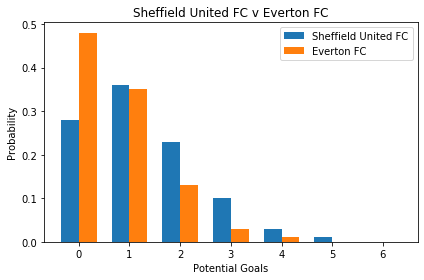

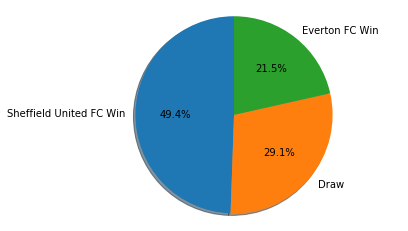

Match date 2020-07-20T17:00:00Z


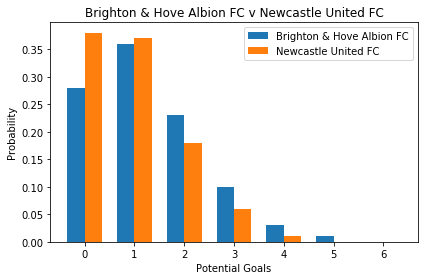

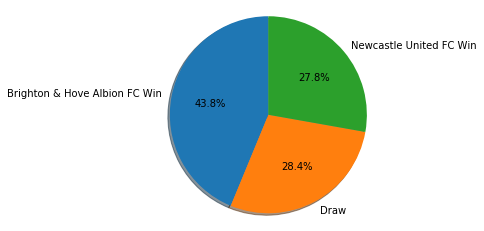

Match date 2020-07-20T19:15:00Z


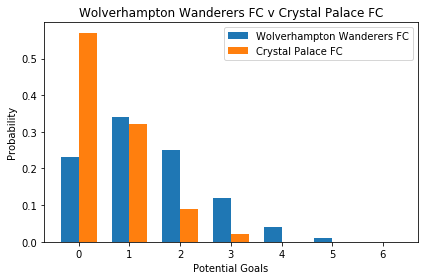

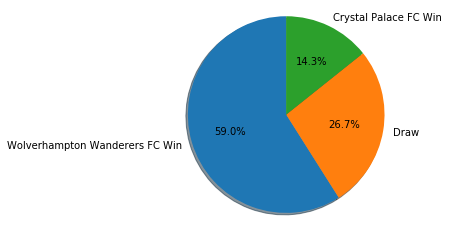

Match date 2020-07-21T17:00:00Z


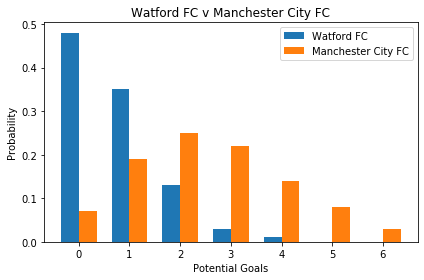

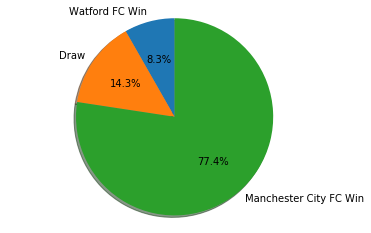

Match date 2020-07-21T19:15:00Z


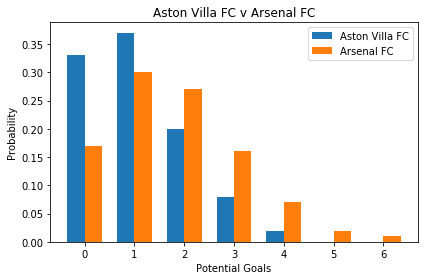

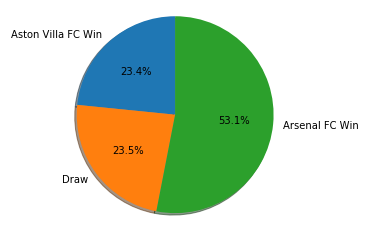

Match date 2020-07-22T17:00:00Z


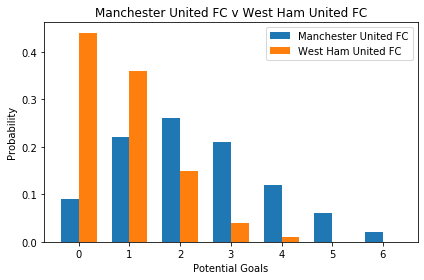

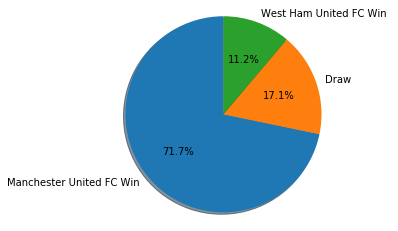

Match date 2020-07-22T19:15:00Z


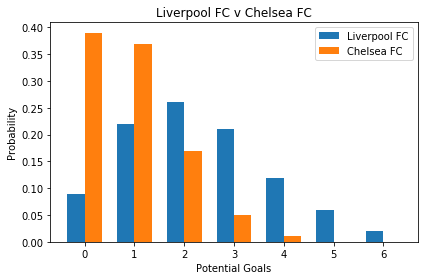

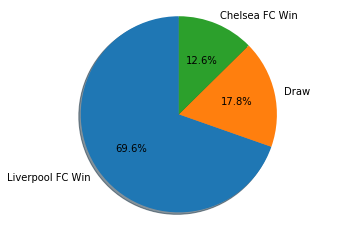

Match date 2020-07-26T15:00:00Z


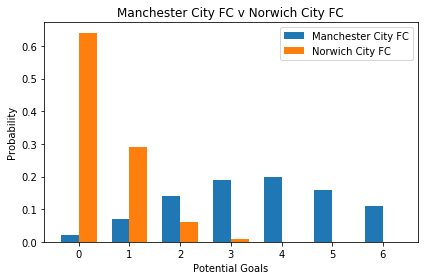

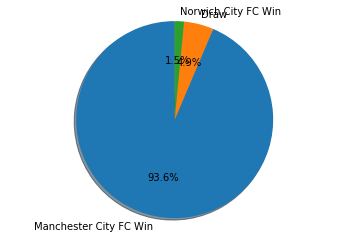

Match date 2020-07-26T15:00:00Z


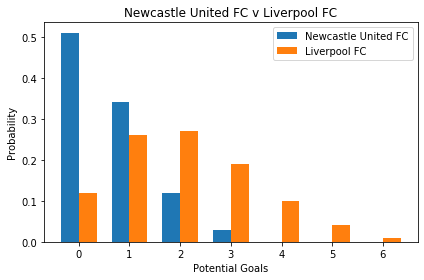

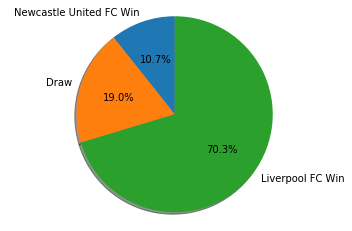

Match date 2020-07-26T15:00:00Z


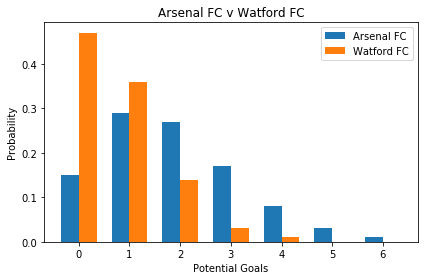

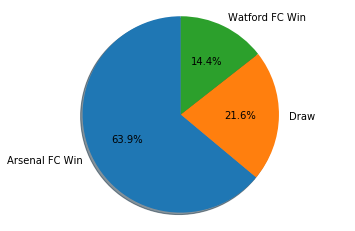

Match date 2020-07-26T15:00:00Z


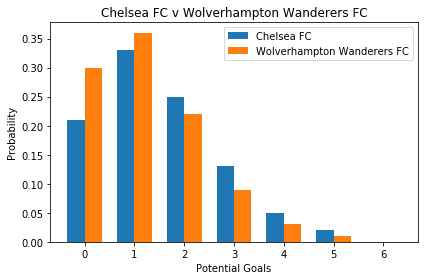

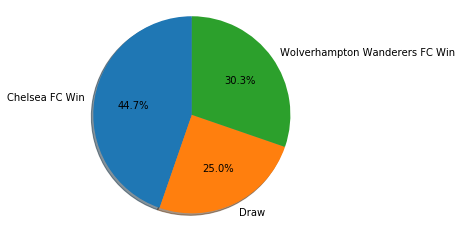

Match date 2020-07-26T15:00:00Z


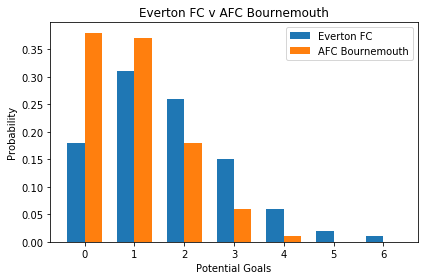

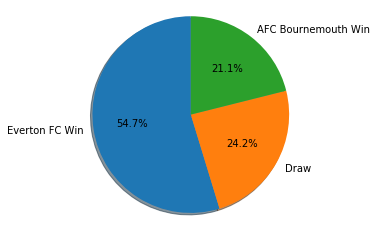

Match date 2020-07-26T15:00:00Z


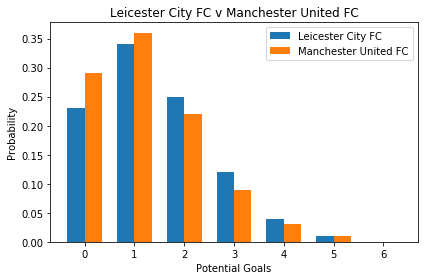

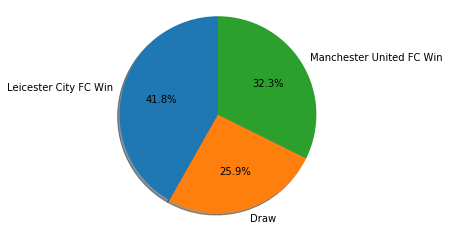

Match date 2020-07-26T15:00:00Z


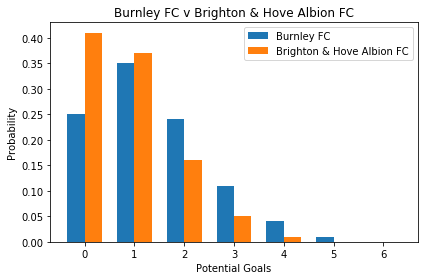

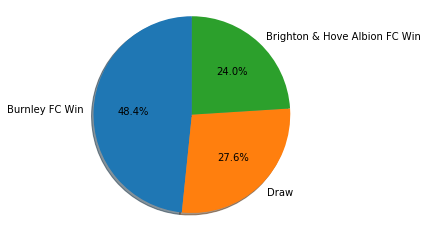

Match date 2020-07-26T15:00:00Z


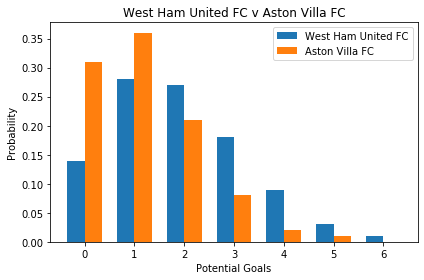

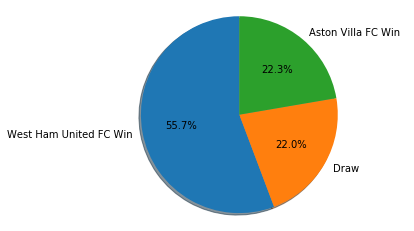

Match date 2020-07-26T15:00:00Z


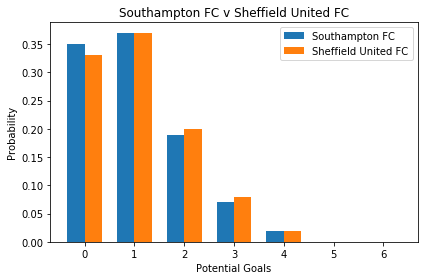

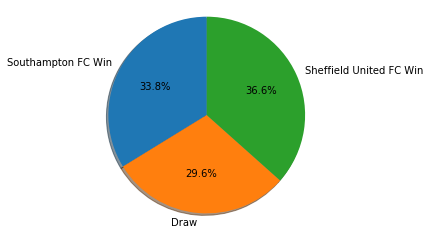

Match date 2020-07-26T15:00:00Z


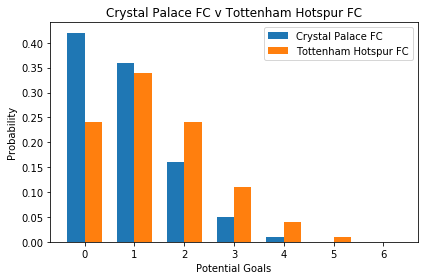

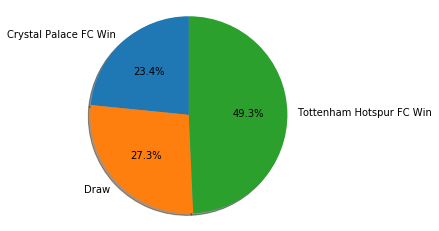

In [7]:
matches = matches_response.json()['matches']
teams = sorted(list(home_df.team.values))

for match in matches:
    utcDate = match['utcDate']
    home_team = match['homeTeam']['name']
    away_team = match['awayTeam']['name']
    print(f'Match date {utcDate}')
    footy.score_probability(home_team, away_team)
    footy.outcome_probability(home_team, away_team)

    if home_team in teams:
        teams.remove(home_team)

    if away_team in teams:
        teams.remove(away_team)

    if not len(teams):
        break